In [2]:
from matplotlib.patches import Circle, Wedge, Polygon
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from scipy.stats import linregress
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib as mpl
from scipy import stats
import pandas as pd
import logging, sys
import numpy as np
import statistics
import warnings
import argparse
import datetime
import logging
import shutil
import time
import glob
import math
import sys
import csv
import os

In [3]:
warnings.filterwarnings("ignore")

logging.disable(sys.maxsize)
if not sys.warnoptions:
    warnings.simplefilter("ignore")

logging.disable(sys.maxsize)

### Path to your files and masterbias

In [5]:
data_dir_base ="/Users/angelicapsaridi/Documents/Geneva/Recommissioning/Data/2022-06-19/" # Raw data stored

os.chdir(data_dir_base)
masterBias = []


hdu_list = fits.open('masterbias.fits')
masterBias = hdu_list[0].data

### Find LED frames

In [6]:
leds = []

for frame in glob.glob("ECAM.*.fits"):
    hdul = fits.open(frame)
    hdr = hdul[0].header 
    if hdr['OBJECT'] == "led" and hdr['FILTER'] == "VG":
         #if hdr['EXPTIME'] >=48 and hdr['EXPTIME'] <49:
        leds.append(hdr['ARCFILE'])
leds.sort()

### Calculate variance and signal for each quadrant

In [7]:
varUL = []
signalUL = []
varUR = []
signalUR = []
varLL = []
signalLL = []
varLR = []
signalLR = []

In [8]:
k = 0
for i in range(len(leds)):
     for j in range(i+1): 
        if i!=j:
            exposure1 = fits.open(leds[i])[0].header['EXPTIME']
            exposure2 = fits.open(leds[j])[0].header['EXPTIME']
            if (str(exposure1)[0:2])==(str(exposure2)[0:2]) and exposure1!=15.0010004 and exposure1!=15.0019999 and exposure1!=15:
                    k = k+1
                    Ccube1 = fits.open(leds[i], mode='update')
                    flatA = (Ccube1[0].data[100:4212,100:4196])-masterBias

                    Ccube2 = fits.open(leds[j], mode='update')
                    flatB = (Ccube2[0].data[100:4212,100:4196])-masterBias
                    #LL
                    centx, centy = 1000, 1000
                    squareSide = 100

                    meanA = np.mean(flatA[(centx-squareSide):(centx+squareSide) ,
                                              (centy-squareSide):(centy+squareSide)])


                    meanB = np.mean(flatB[(centx-squareSide):(centx+squareSide) ,
                                              (centy-squareSide):(centy+squareSide)])

                    r = meanA/meanB
                    flatBnew = flatB*r
                    k = flatA-flatBnew
                    stdK = np.std(k[(centx-squareSide):(centx+squareSide) ,
                                              (centy-squareSide):(centy+squareSide)])
                    varLL.append((stdK**2)/2)
                    signalLL.append(meanA)
                    #UL

                    centx, centy = 1000, 3000
                    squareSide = 100

                    meanA = np.mean(flatA[(centx-squareSide):(centx+squareSide) ,
                                              (centy-squareSide):(centy+squareSide)])


                    meanB = np.mean(flatB[(centx-squareSide):(centx+squareSide) ,
                                              (centy-squareSide):(centy+squareSide)])

                    r = meanA/meanB
                    flatBnew = flatB*r
                    k = flatA-flatBnew
                    stdK = np.std(k[(centx-squareSide):(centx+squareSide) ,
                                              (centy-squareSide):(centy+squareSide)])
                    varUL.append((stdK**2)/2)
                    signalUL.append(meanA)
                    #LR

                    centx, centy = 3000, 1000
                    squareSide = 100

                    meanA = np.mean(flatA[(centx-squareSide):(centx+squareSide) ,
                                              (centy-squareSide):(centy+squareSide)])


                    meanB = np.mean(flatB[(centx-squareSide):(centx+squareSide) ,
                                              (centy-squareSide):(centy+squareSide)])

                    r = meanA/meanB
                    flatBnew = flatB*r
                    k = flatA-flatBnew
                    stdK = np.std(k[(centx-squareSide):(centx+squareSide) ,
                                              (centy-squareSide):(centy+squareSide)])
                    varLR.append((stdK**2)/2)
                    signalLR.append(meanA)

                    #UR

                    centx, centy = 3000, 3000
                    squareSide = 100

                    meanA = np.mean(flatA[(centx-squareSide):(centx+squareSide) ,
                                              (centy-squareSide):(centy+squareSide)])


                    meanB = np.mean(flatB[(centx-squareSide):(centx+squareSide) ,
                                              (centy-squareSide):(centy+squareSide)])

                    r = meanA/meanB
                    flatBnew = flatB*r
                    k = flatA-flatBnew
                    stdK = np.std(k[(centx-squareSide):(centx+squareSide) ,
                                              (centy-squareSide):(centy+squareSide)])
                    varUR.append((stdK**2)/2)
                    signalUR.append(meanA)




### Fit polynomial to calculate gain

In [16]:
#LL
print('Lower left quadrant')
polyFit = np.polyfit(signalLL, varLL, deg=1, cov = True)

a1, a0 = polyFit[0]


gain = 1/a1

slope_err = polyFit[1][0,0]
gain_err = gain * slope_err / a1
mean_fit = np.linspace(20,2400,1000)
variance_fit = a0 + a1 * mean_fit
print('The gain of the CCD is',np.round(gain,3),'electrons/ADU')
print('The gain error',np.round(gain_err,4),'electrons/ADU')

#LR
print('Lower right quadrant')

polyFit = np.polyfit(signalLR, varLR, deg=1, cov = True)

a1, a0 = polyFit[0]


gain = 1/a1

slope_err = polyFit[1][0,0]
gain_err = gain * slope_err / a1
mean_fit = np.linspace(20,2400,1000)
variance_fit = a0 + a1 * mean_fit
print('The gain of the CCD is',np.round(gain,3),'electrons/ADU')
print('The gain error',np.round(gain_err,4),'electrons/ADU')

#UL
print('Upper left quadrant')

polyFit = np.polyfit(signalUL, varUL, deg=1, cov = True)

a1, a0 = polyFit[0]


gain = 1/a1

slope_err = polyFit[1][0,0]
gain_err = gain * slope_err / a1
mean_fit = np.linspace(20,2400,1000)
variance_fit = a0 + a1 * mean_fit
print('The gain of the CCD is',np.round(gain,3),'electrons/ADU')
print('The gain error',np.round(gain_err,4),'electrons/ADU')

#UR
print('Upper right quadrant')


polyFit = np.polyfit(signalUR, varUR, deg=1, cov = True)

a1, a0 = polyFit[0]


gain = 1/a1

slope_err = polyFit[1][0,0]
gain_err = gain * slope_err / a1
mean_fit = np.linspace(20,2400,1000)
variance_fit = a0 + a1 * mean_fit
print('The gain of the CCD is',np.round(gain,3),'electrons/ADU')
print('The gain error',np.round(gain_err,4),'electrons/ADU')

Lower left quadrant
The gain of the CCD is 2.777 electrons/ADU
The gain error 0.0004 electrons/ADU
Lower right quadrant
The gain of the CCD is 2.754 electrons/ADU
The gain error 0.0004 electrons/ADU
Upper left quadrant
The gain of the CCD is 2.735 electrons/ADU
The gain error 0.0005 electrons/ADU
Upper right quadrant
The gain of the CCD is 2.647 electrons/ADU
The gain error 0.0038 electrons/ADU


### Plot gain graph

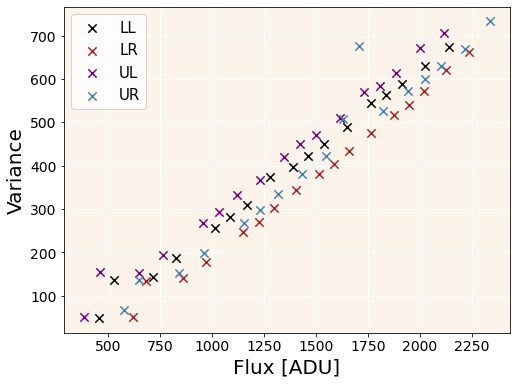

In [15]:
fig = plt.figure(figsize=(8, 6)) 
ax = plt.subplot()
ax.scatter(signalLL, varLL,color='black',marker='x',zorder=40,s=70,label='LL')
ax.scatter(signalLR, varLR,color='firebrick',marker='x',zorder=40,s=70,label='LR')
ax.scatter(signalUL, varUL,color='purple',marker='x',zorder=40,s=70,label='UL')
ax.scatter(signalUR, varUR,color='steelblue',marker='x',zorder=40,s=70,label='UR')



ax.legend(fontsize=15)

ax.set_facecolor('antiquewhite')
ax.patch.set_alpha(.5)
ax.grid(color='white', linestyle='-', linewidth=1)
ax.set_ylabel("Variance",fontsize=20)
ax.set_xlabel("Flux [ADU]",fontsize=20)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
